In [31]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import FragmentIonIntensityDataset

In [38]:
model_name = 'c_r_FiLM_full_d10_static_0.0005_kq4.keras'

model = keras.saving.load_model('/nfs/home/students/d.lochert/projects/astral/dlomix-astral/saved_models/%s' % model_name, 
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
model.summary()

(1024, 30, 512)
(1024, 1, 5120)


In [34]:
int_data = FragmentIonIntensityDataset.load_from_disk("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/combined_dataset")

In [35]:
tmp = [m for m in int_data.tensor_train_data.take(100)][0][0]

res = model.get_meta_vector(tmp)

res = tf.split(res, 20, axis=-1)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8df824eda0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8df824d7e0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8df8127370>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8df8125c90>}

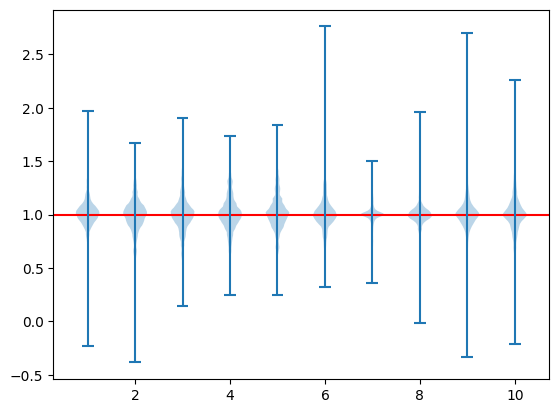

In [36]:
# Plot scaling vector
vals = [tf.reshape(res[i], [-1])+1 for i in range(0, 20, 2)]
keys = np.array([i for i in range(1, 11)])

plt.axhline(y=1, color='r', linestyle='-')
plt.violinplot(vals, keys) 

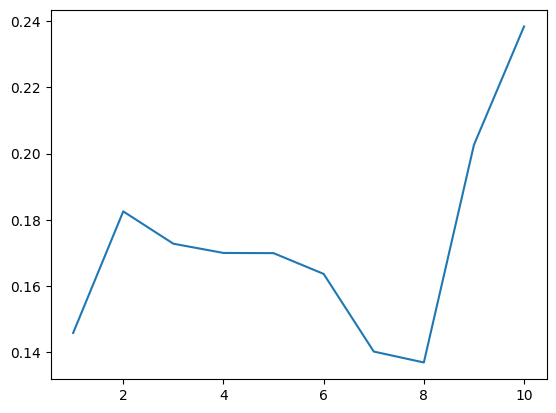

In [37]:
std = [tf.math.reduce_std(v) for v in vals]
plt.plot(keys, std)

In [ ]:
# Plot shift vector
vals = [tf.reshape(res[i], [-1]) for i in range(1, 20, 2)]
keys = np.array([i for i in range(1, 11)])

plt.axhline(y=0, color='r', linestyle='-')
plt.violinplot(vals, keys)

In [27]:
std = [tf.math.reduce_std(v) for v in vals]
plt.plot(keys, std)
